I made a few changes. Unfortunately we were counting the same patients repeatedly so I grouped by patient and ran the classifier models. Currently it looks like they are overfitting so I will play with them some more. 

In [67]:
import numpy as np
import pandas as pd
import os
import datetime
os.getcwd()

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [68]:
projectdf = pd.read_csv('data/coherent-11-07-2022/csv/NewMemYear.csv')
projectdf2 = pd.read_csv('data/coherent-11-07-2022/csv/NewMemYear.csv')
conditionsdf = pd.read_csv('Conditions_ohc.csv')
chemo_pats = pd.read_csv('chemo_pats.csv')

In [100]:
conditionsdrop_list = ['DeceasedFlag', 'CHEMO', 'Alcoholism', 'Anemia (disorder)',
       'Blindness due to type 2 diabetes mellitus (disorder)',
       'Body mass index 30+ - obesity (finding)',
       'Body mass index 40+ - severely obese (finding)',
       'Chronic kidney disease stage 1 (disorder)',
       'Chronic kidney disease stage 2 (disorder)',
       'Chronic obstructive bronchitis (disorder)', 'Diabetes',
       'Diabetic retinopathy associated with type II diabetes mellitus (disorder)',
       'Hyperglycemia (disorder)', 'Hyperlipidemia', 'Hypertension',
       'Hypertriglyceridemia (disorder)', 'Lupus erythematosus',
       'Macular edema and retinopathy due to type 2 diabetes mellitus (disorder)',
       'Metabolic syndrome X (disorder)',
       'Microalbuminuria due to type 2 diabetes mellitus (disorder)',
       'Neuropathy due to type 2 diabetes mellitus (disorder)',
       'Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder)',
       'Opioid abuse (disorder)', 'Prediabetes',
       'Primary fibromyalgia syndrome',
       'Proliferative diabetic retinopathy due to type II diabetes mellitus (disorder)',
       'Pulmonary emphysema (disorder)', 'Rheumatoid arthritis',
       'Shock (disorder)', 'Stroke', 'Chronic congestive heart failure (disorder)', 'Atrial Fibrillation',
       'Cardiac Arrest', 'Coronary Heart Disease',
       'History of cardiac arrest (situation)',
       'History of myocardial infarction (situation)', 'Myocardial Infarction', 'Cardiac Event']

In [70]:
# Looking at specific chemo drugs -- this code creates dummies for them and groups by patient
chemo_ohc = chemo_pats[['PATIENT']].join(pd.get_dummies(chemo_pats['DESCRIPTION'])).groupby('PATIENT').max()

In [71]:
projectdf.drop(['MemYear', 'emergency', 'inpatient', 'outpatient', 'urgentcare', 'wellness', 'ER_Visits', 'Inpt_Admits'], axis=1, inplace=True)

In [72]:
cancer_list = ['Carcinoma in situ of prostate (disorder)',
       'Malignant neoplasm of breast (disorder)', 'Malignant tumor of colon',
       'Metastasis from malignant tumor of prostate (disorder)',
       'Neoplasm of prostate',
       'Non-small cell carcinoma of lung  TNM stage 1 (disorder)',
       'Non-small cell lung cancer (disorder)',
       'Primary malignant neoplasm of colon',
       'Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)',
       'Secondary malignant neoplasm of colon',
       'Suspected lung cancer (situation)']

# New df to attempt date calculations
dateattempt = projectdf2[projectdf2[cancer_list].any(axis=1)]
dateattempt2 = projectdf2[projectdf2['Chronic congestive heart failure (disorder)']==True]

# Query first and last years for any cancer column containing a true value and caluculate difference
date2 = dateattempt.groupby('PATIENT').agg(CAFirstYear=('MemYear', 'min'), CALastYear=('MemYear', 'max'))
date2['CADuration'] = date2['CALastYear']-date2['CAFirstYear']

# Query first year CHF column contains a true value and caluculate difference from initial cancer diagnosis
chfdate = dateattempt2.groupby('PATIENT').agg(CHFDiagnosisYear=('MemYear', 'min'))
chfdate['DelaytoCHF']=chfdate['CHFDiagnosisYear']-date2['CAFirstYear']


In [73]:
#There are no values less than zero in the CHF time to diagnosis. 
chfdate[chfdate['DelaytoCHF']<1].any()

CHFDiagnosisYear    False
DelaytoCHF          False
dtype: bool

In [74]:
# Group all the patient info into one line for each patient
projectdf = projectdf.groupby('PATIENT').max()

In [75]:
# Add the one hot encoded chemo drugs to the conditions df.
projectdf = projectdf.join(chemo_ohc, on='PATIENT', how = 'left')

In [76]:
# Join timeline dfs to main df
projectdf = projectdf.join(date2['CADuration'], on='PATIENT', how='left')

In [77]:
#projectdf=projectdf.reset_index().drop(['Unnamed: 0'], axis=1)

In [78]:
# Assess for null values and fill null conditions with '0'
projectdf.isnull().sum()
projectdf.fillna(0, inplace=True)

In [103]:
Y = projectdf['Chronic congestive heart failure (disorder)']
# X = projectdf.drop(['Chronic congestive heart failure (disorder)', 'Atrial Fibrillation',
#        'Cardiac Arrest', 'Coronary Heart Disease',
#        'History of cardiac arrest (situation)',
#        'History of myocardial infarction (situation)', 'Myocardial Infarction', 'Cardiac Event'], axis=1)
X = projectdf.drop(conditionsdrop_list, axis=1)

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [105]:
from sklearn.linear_model import Lasso

In [106]:
rfc = RandomForestClassifier(random_state=42)
rfc.get_params()

param_grid = {
            'max_depth': [5, 10, 15, 20, 25],
            'n_estimators': [10, 15, 25, 50, 100],
            'n_jobs': [-1]}

cv = KFold(n_splits=5)



In [107]:
cv_mod = GridSearchCV(rfc, param_grid=param_grid, cv=cv)

In [108]:
gridcv = cv_mod.fit(X_train, Y_train)
gridcv.best_params_

{'max_depth': 5, 'n_estimators': 15, 'n_jobs': -1}

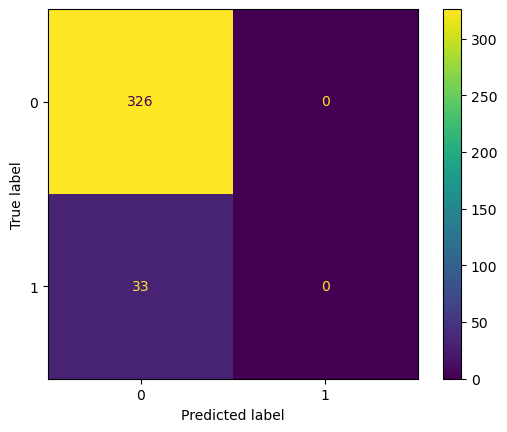

In [109]:
_ = ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_train, Y_train)

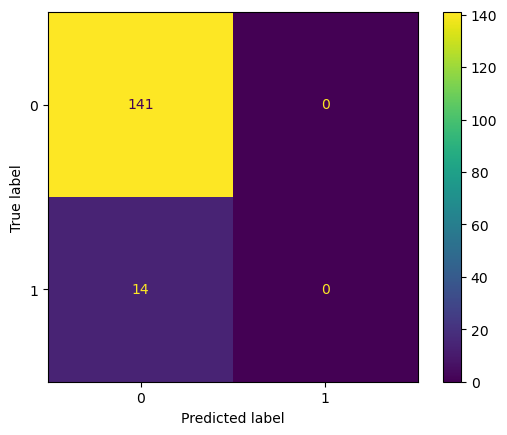

In [110]:
_ = ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_test, Y_test)

In [111]:
ada = AdaBoostClassifier(random_state=42)
ada.get_params()

param_grid = {
            'learning_rate': [0.5, 0.8, 15],
            'n_estimators': [10, 15, 25, 50, 100],
            'n_jobs': [-1]}

cv = KFold(n_splits=5)


In [112]:
adacv_mod = GridSearchCV(ada, param_grid=param_grid, cv=cv)

In [113]:
adagridcv = cv_mod.fit(X_train, Y_train)
adagridcv.best_params_

{'max_depth': 5, 'n_estimators': 15, 'n_jobs': -1}

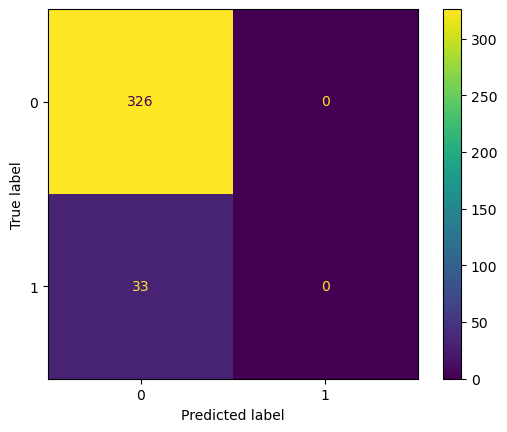

In [114]:
_ = ConfusionMatrixDisplay.from_estimator(adagridcv.best_estimator_, X_train, Y_train)

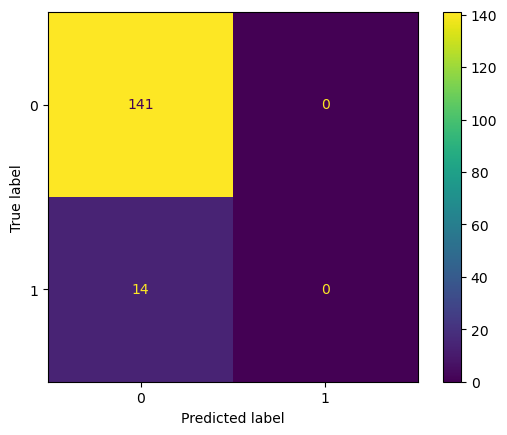

In [115]:
_ = ConfusionMatrixDisplay.from_estimator(adagridcv.best_estimator_, X_test, Y_test)

In [116]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [117]:
C_candidates = np.logspace(-2, 0, 20) #Grid of 20 points between 10^-2 and 10^0 (which is 1)
gamma_candidates = np.logspace(-2, 1, 20) #Grid of 20 points between 10^-2 and 10^1 (which is 10)

In [118]:
svm_pipeline = make_pipeline(StandardScaler(), #Scaling features-- want to make sure our distance computations are dominated by predictors that have large variability
                             SVC(random_state=42))


In [119]:
#Looking in a "box" 20 points on gamma axis (depth) and 20 points on x? axis (width); either way 400 candidates total
grid_search_cv = GridSearchCV(svm_pipeline, 
                              dict(svc__C=C_candidates, svc__gamma=gamma_candidates), #C parameter is the marginal regularlization strength
                              cv=cv).fit(X_train, Y_train) #two folds defined above

grid_search_cv.best_params_

{'svc__C': 1.0, 'svc__gamma': 2.3357214690901213}

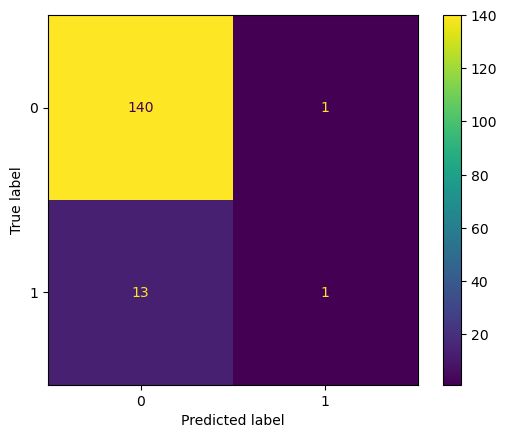

In [120]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search_cv.best_estimator_, X_test, Y_test)

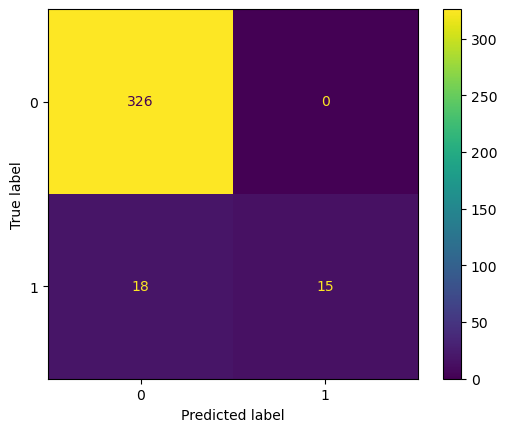

In [122]:
_ = ConfusionMatrixDisplay.from_estimator(grid_search_cv.best_estimator_, X_train, Y_train)